Sample 0: IoU Score = 0.7462


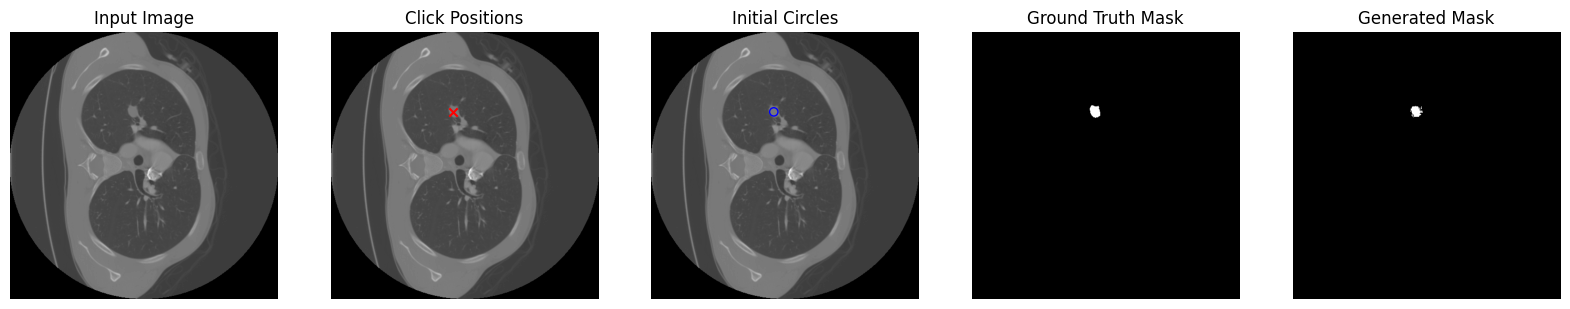

Sample 1: IoU Score = 0.0000


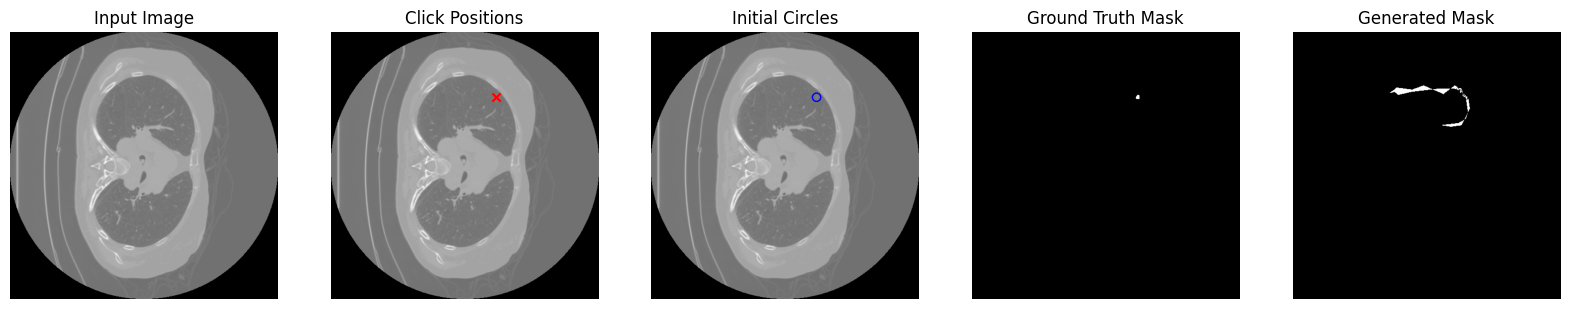

Sample 2: IoU Score = 0.4875


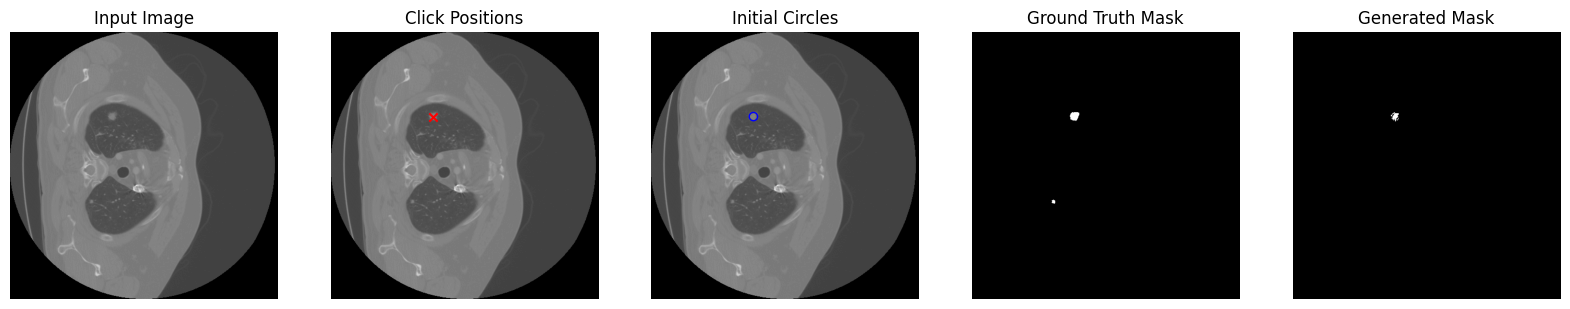

Sample 3: IoU Score = 0.1466


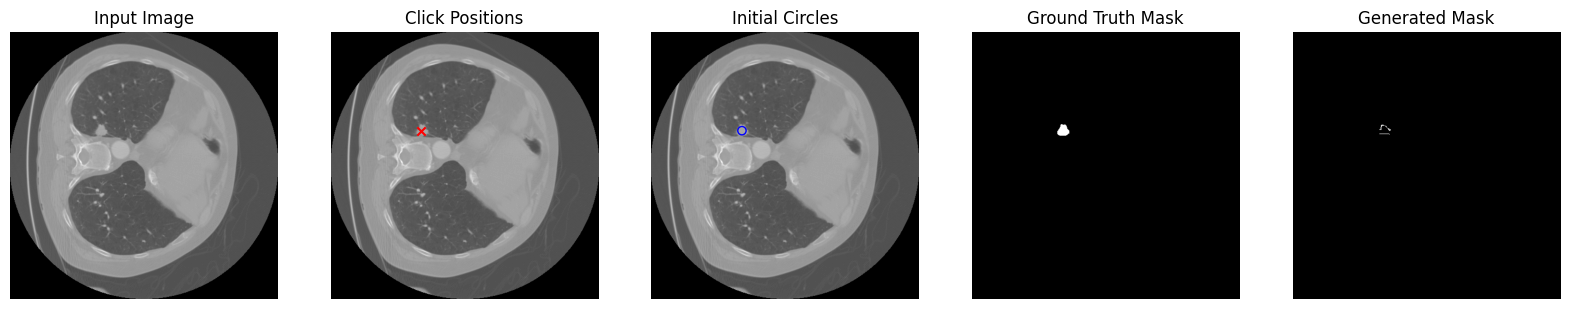

Sample 4: IoU Score = 0.2222


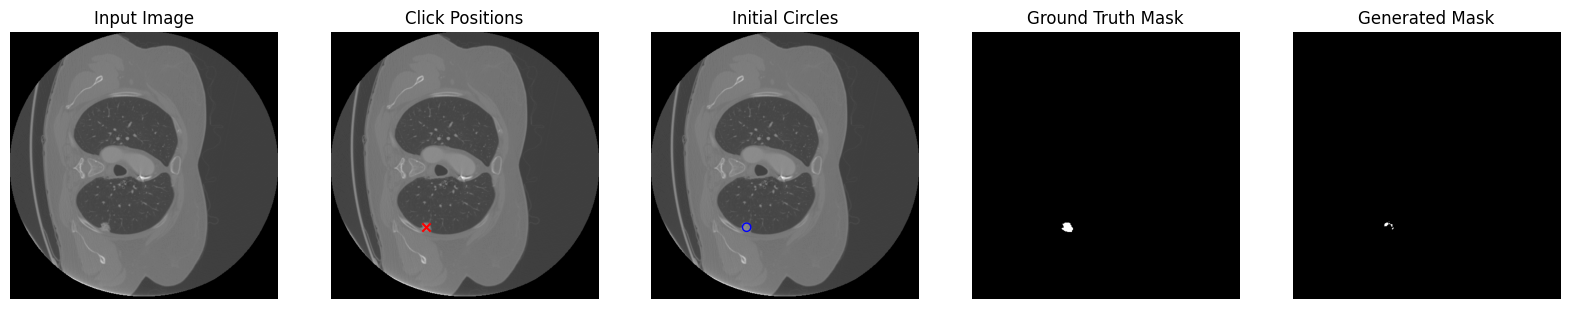

Sample 5: IoU Score = 0.4068


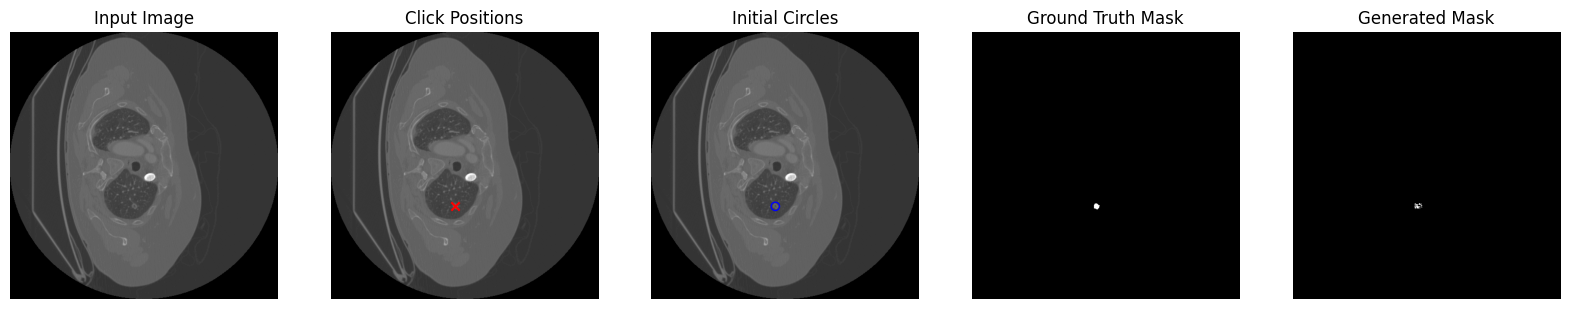

Sample 6: IoU Score = 0.5227


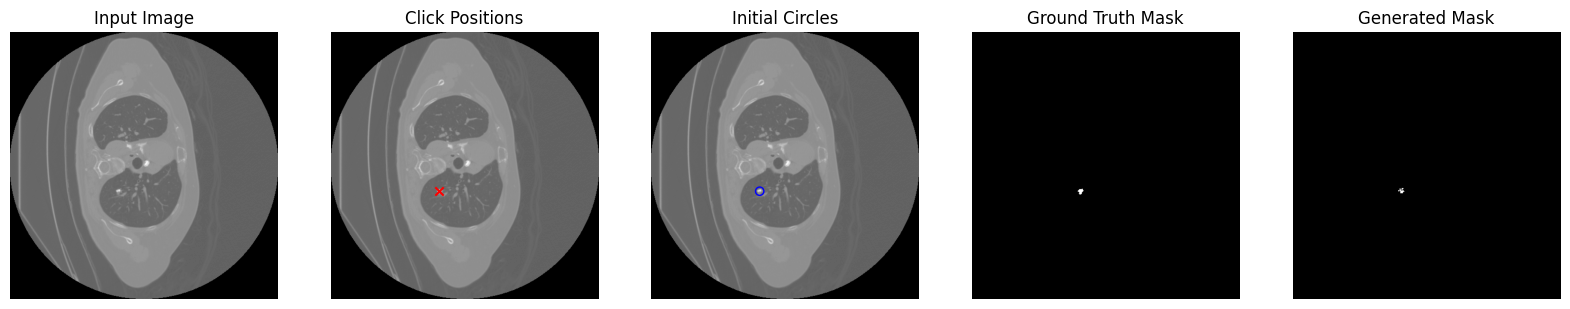

Sample 7: IoU Score = 0.6712


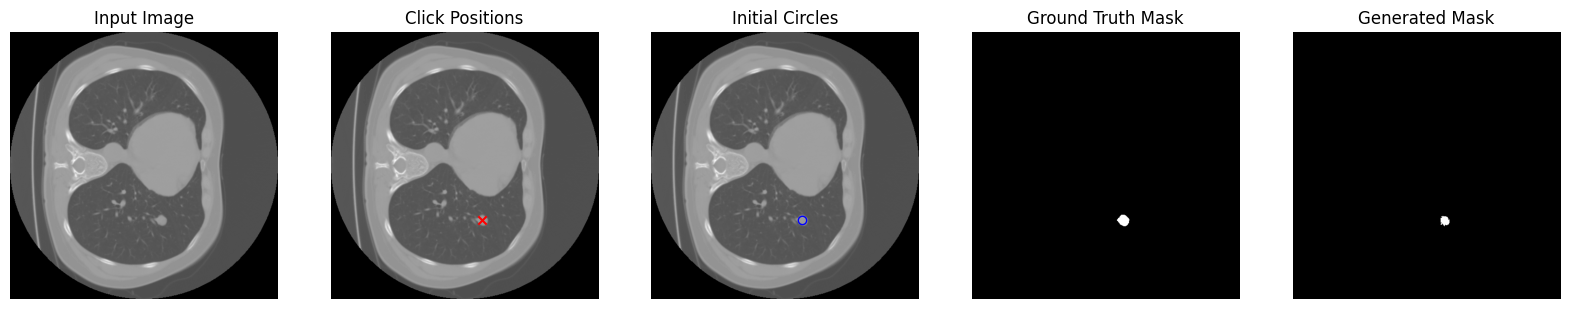

Sample 8: IoU Score = 0.7585


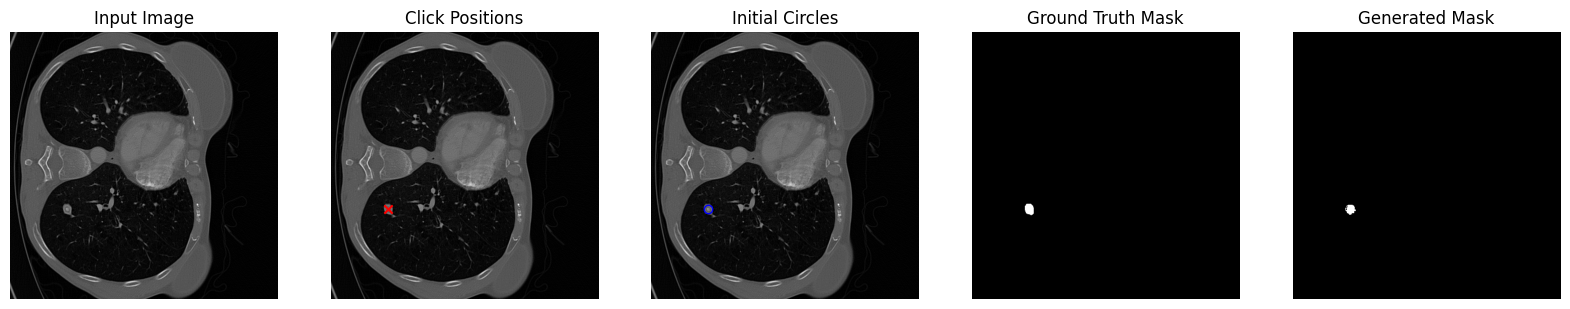

Sample 9: IoU Score = 0.7582


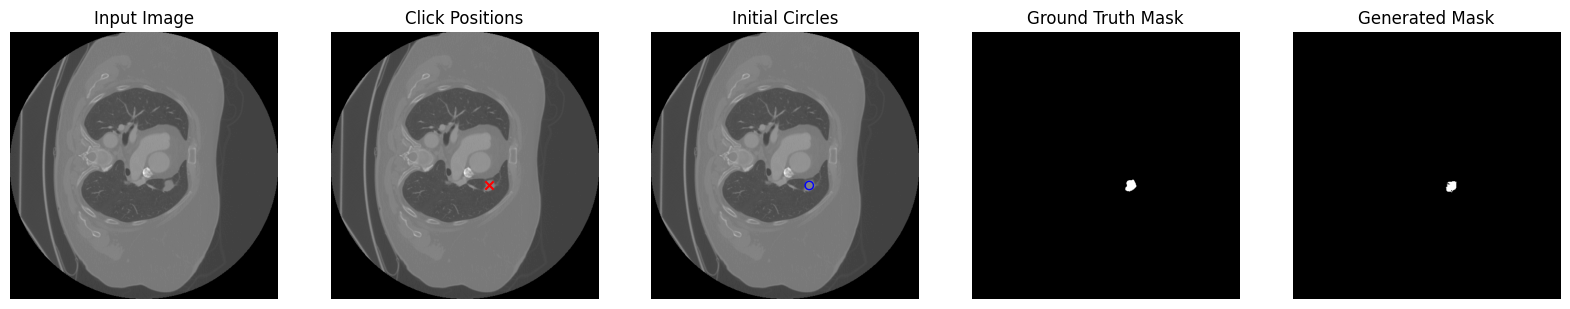

In [5]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from isegm.classical_approaches.snake_fill import SnakeMasker
from isegm.data.datasets import Lidc2dDataset
from torch.utils.data import DataLoader
from albumentations import Compose, Normalize
from sklearn.metrics import jaccard_score

# Define paths
base_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D'
dataset_name = 'val'

# Specific parameter for SnakeMasker
circle_size_param = 8
masker = SnakeMasker(circle_size=circle_size_param)

# Prepare the dataset
dataset_path = os.path.join(base_path, dataset_name)
dataset = Lidc2dDataset(data_dir=dataset_path)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Process the first 10 samples in the validation set
for i, (image, gt_mask) in enumerate(data_loader):
    if i >= 10:
        break
    
    image_np = image.squeeze().numpy()
    
    gt_mask = gt_mask.squeeze().numpy()
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        gt_mask.astype(np.uint8)
    )
    
    # Sort the components based on their sizes, in descending order
    sorted_indices = np.argsort(-stats[:, cv2.CC_STAT_AREA])

    # Reorder stats and centroids based on sorted indices
    sorted_stats = stats[sorted_indices]
    sorted_centroids = centroids[sorted_indices]

    # Reorder labels array
    sorted_labels = np.zeros_like(labels)
    for new_label, old_label in enumerate(sorted_indices):
        sorted_labels[labels == old_label] = new_label

    num_labels = min(num_labels, 1+1)
    
    coords = [(int(sorted_centroids[label][0]), int(sorted_centroids[label][1]))
              for label in range(1, num_labels)]
    
    pred_mask = masker.predict(image_np, coords).astype(bool)
    
    # Calculate IoU score
    iou_score = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
    print(f'Sample {i}: IoU Score = {iou_score:.4f}')
    
    # Visualization
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title('Input Image')
    
    axes[1].scatter(*zip(*coords), c='red', marker='x')
    axes[1].imshow(image_np, cmap='gray')
    axes[1].set_title('Click Positions')
    
    for coord in coords:
        circle = plt.Circle((coord[0], coord[1]), circle_size_param, color='blue', fill=False)
        axes[2].add_patch(circle)
    axes[2].imshow(image_np, cmap='gray')
    axes[2].set_title('Initial Circles')
    
    axes[3].imshow(gt_mask, cmap='gray')
    axes[3].set_title('Ground Truth Mask')
    
    axes[4].imshow(pred_mask, cmap='gray')
    axes[4].set_title('Generated Mask')
    
    for ax in axes:
        ax.axis('off')
    
    plt.show()

In [12]:
import numpy as np
import cv2
import os
import pandas as pd
from isegm.classical_approaches.snake_fill import SnakeMasker
from isegm.data.datasets import Lidc2dDataset
from torch.utils.data import DataLoader
from albumentations import Compose, Normalize
from sklearn.metrics import jaccard_score
from isegm.inference.utils import get_iou, get_f1_score

# Define paths
base_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D'
dataset_name = 'val'

# Define transformations for normalization
transformations = Compose([Normalize(mean=0, std=1)])

# Specific parameter for SnakeMasker
circle_size_param = 8
masker = SnakeMasker(circle_size=circle_size_param)

# Prepare the dataset
dataset_path = os.path.join(base_path, dataset_name)
dataset = Lidc2dDataset(data_dir=dataset_path, transform=transformations)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Sample', 'IoU Score', 'F1 Score'])

# Process samples in the data loader
for i, (image, gt_mask) in enumerate(data_loader):
    print(f'Masking sample: {i}')
    image_np = image.squeeze().numpy()
    
    gt_mask = gt_mask.squeeze().numpy()
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(gt_mask.astype(np.uint8))
    sorted_indices = np.argsort(-stats[:, cv2.CC_STAT_AREA])
    sorted_stats = stats[sorted_indices]
    sorted_centroids = centroids[sorted_indices]

    num_labels = min(num_labels, 2)
    coords = [(int(sorted_centroids[label][0]), int(sorted_centroids[label][1])) for label in range(1, num_labels)]
    
    pred_mask = masker.predict(image_np, coords).astype(bool)
    iou_score = get_iou(gt_mask, pred_mask)
    f1_score = get_f1_score(gt_mask, pred_mask)
    
    # Save results in the DataFrame
    results_df = results_df.append({'Sample': i, 'IoU Score': iou_score, 'F1 Score': f1_score}, ignore_index=True)
    
    if i > 10:
        break

# Calculate mean IoU
mean_iou = results_df['IoU Score'].mean()
print(f'Mean IoU Score: {mean_iou:.4f}')
mean_f1_score = results_df['F1 Score'].mean()
print(f'Mean F1 Score: {mean_f1_score:.4f}')


Masking sample: 0
Masking sample: 1
Masking sample: 2
Masking sample: 3
Masking sample: 4
Masking sample: 5
Masking sample: 6
Masking sample: 7
Masking sample: 8
Masking sample: 9
Masking sample: 10
Masking sample: 11
Mean IoU Score: 0.5044
Mean F1 Score: 0.6232
